# Fit atmosphere parameters including clouds using wavelet decomposition on Spectra

- author Sylvie Dagoret-Campagne

- creation date August 24th 2020 : Fit on Spectra


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [4]:
import libatmscattering as atm

## Functions

In [5]:
def plot_param(iparam,ax,all_Yin,all_Yout,mode,nsig=10):
    """
    plot parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    xlabel=["VAOD in ","PWV in (mm)","Ozone in (dBU)","Cloud OD in "]
    ylabel=["value out","value rec - value in","$\delta V/V$"]
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]
     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    
    if mode   ==0:  
        cm=ax.plot(Y0,Y1,"o",color=all_colors[iparam])
    elif mode ==1:
        
        mu = DY.mean()
        median = np.median(DY)
        sigma = DY.std()
        textstr = '\n'.join((
        '$\mu$={:.3g}'.format(mu),
        '$median$={:.3g}'.format(median),
        '$\sigma$={:.3g}'.format(sigma)))
        
       
        cm=ax.plot(Y0,DY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)
        
    else:
        
        mu = RY.mean()
        median = np.median(RY)
      
        sigma = RY.std()
        
        
        textstr = '\n'.join((
        '$\mu$={:.3g}'.format(mu),
        '$median$={:.3g}'.format(median),
        '$\sigma$={:.3g}'.format(sigma)))
       
        
        
        cm=ax.plot(Y0,RY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
            
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)    
            
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_ylabel(ylabel[mode])

    
    ax.ticklabel_format(axis='y',style='sci', 
                          scilimits=None, 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm


In [6]:
def plot_param_histo(iparam,ax,all_Yin,all_Yout,nsig=10):
    """
    plot histo of parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    

    xlabel=["$\Delta$ VAOD","$\Delta$ PWV (mm)","$\Delta$ Ozone (dBU)","$\Delta$ OD"]
   
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    
    mu = DY.mean()
    median = np.median(DY)
    sigma = DY.std()
    textstr = '\n'.join((
    '$\mu$={:.3g}'.format(mu),
    '$median$={:.3g}'.format(median),
    '$\sigma$={:.3g}'.format(sigma)))
   
    
    cm=ax.hist(DY,bins=50,color=all_colors[iparam])
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_xlim(mu-nsig*sigma,mu+nsig*sigma)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
 
    ax.ticklabel_format(axis='x', 
                          style='sci',
                          scilimits=None, 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm


# Input files : wavelet decomposition coefficients

In [7]:
all_files=["lsst_atm_10year_waveletsspectra_dataset1_cld.fits",
           "lsst_atm_10year_waveletsspectra_dataset2_cld.fits",
           "lsst_atm_10year_waveletsspectra_dataset3_cld.fits",
           "lsst_atm_10year_waveletsspectra_dataset4_cld.fits",
           "lsst_atm_10year_waveletsspectra_dataset5_cld.fits",
           "lsst_atm_10year_waveletsspectra_dataset6_cld.fits",
           "lsst_atm_10year_waveletsspectra_dataset7_cld.fits",
           "lsst_atm_10year_waveletsspectra_dataset8_cld.fits",
           "lsst_atm_10year_waveletsspectra_dataset9_cld.fits"]

### Level of decomposition

- ilevel : from 1 to 9

In [8]:
ilevel=2
ilevel_label="wavelet decomp level {}".format(ilevel)

In [9]:
input_file=all_files[ilevel]

In [10]:
hdu = fits.open(input_file)

In [11]:
hdr=hdu[0].header
data=hdu[0].data

In [12]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   20                                                  
NAXIS2  =                 3650                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [13]:
NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [14]:
num=data[0:,idx_out_num]
year=data[0:,idx_out_year]
airmass=data[0:,idx_out_year]
vaod=data[0:,idx_out_vaod] # vertical aerosol depth
pwv=data[0:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[0:,idx_out_o3]     # ozone
cld=data[0:,idx_out_cld]   # clouds (not used)

Text(0.5, 0, 'cloud optical depth ')

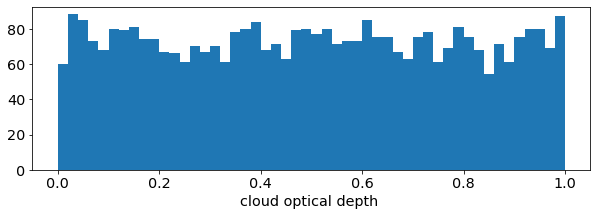

In [15]:
fig=plt.figure(figsize=(10,3))

ax = fig.add_subplot(111)
plt.hist(cld,bins=50,label="in data")
#ax.set_yscale('log')
ax.set_xlabel("cloud optical depth ")

In [16]:
coeff=data[:,idx_out_res:]

In [17]:
N=coeff.shape[1]
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

Text(0, 0.5, 'coefficient value')

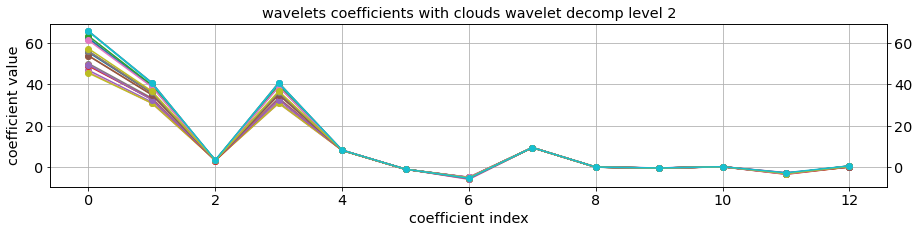

In [18]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
for idx in np.arange(20):
    ax.plot(coeff[idx,:],"o-")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax.grid()
ax.set_title("wavelets coefficients with clouds "+ ilevel_label)
ax.set_xlabel("coefficient index")
ax.set_ylabel("coefficient value")

# Prepare data

In [19]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]
cldarr=cld[:,np.newaxis]

### Y is concatenate VAOD,PWV, Ozone, Clouds

In [20]:
Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)

###  X are the wavelets coefficients

In [21]:
X=coeff

## Splitting

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [23]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [24]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [25]:
FLAG_SCALING=True

In [26]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

StandardScaler()

In [27]:
scaler_X.mean_.shape

(13,)

In [28]:
scaler_X.scale_.shape

(13,)

In [29]:
scaler_Y.mean_.shape

(4,)

In [30]:
scaler_Y.scale_.shape

(4,)

In [31]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

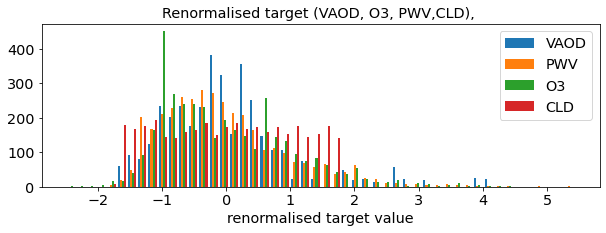

In [32]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50,
        label=["VAOD","PWV","O3","CLD"])
ax.set_title("Renormalised target (VAOD, O3, PWV,CLD), ")
ax.set_xlabel("renormalised target value")
ax.legend()

## Linear regression model

In [33]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [34]:
reg = linear_model.LinearRegression()

In [35]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [36]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


Coefficients: 
 [[ 8.52609685e+02 -5.28264797e+02 -7.76419870e+00 -5.28264797e+02
  -3.43387810e+02  1.08067202e+01  3.04859168e+01  2.03006945e+02
   1.60071367e+02 -1.22134734e+01 -4.41771378e+00 -1.24405280e+01
   1.84486659e+02]
 [ 8.87351922e+01 -6.19468443e+01  4.66582351e+00 -6.19468443e+01
  -7.81505163e+00  1.09599812e+00  3.09019690e+00  3.50273802e+00
   1.08682391e+00 -3.14119434e+00 -8.85055734e-01 -1.70349778e+00
   3.31607903e+01]
 [-6.12108273e+01  4.04194035e+01 -8.35880600e-01  4.04194035e+01
   5.94258513e+00 -6.70746479e-01 -2.65409481e+00 -1.68184287e+00
  -4.19569629e+00  1.05512304e+00  3.37926825e-01  7.85619971e-01
  -1.79332213e+01]
 [-6.17189422e+01  3.88613314e+01  5.87758788e-01  3.88613314e+01
   2.52792799e+01 -7.95049733e-01 -2.24251182e+00 -1.49562084e+01
  -1.17777940e+01  8.98523277e-01  3.25003960e-01  9.15260687e-01
  -1.35720658e+01]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


# Linear Regression with Ridge

In [37]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [38]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

Ridge(alpha=1e-05)
Coefficients: 
 [[  9.29315132   2.77625137  -1.22828965   2.77625137 -22.79062124
    2.31831348  -8.05230069  12.44754326  12.43530728  -2.16593492
   -3.16219815  -3.85805941  -9.79972915]
 [ -4.33245326  -3.0332789    2.66865138  -3.03327891   2.09988532
    1.09400409  -3.53894935  -1.35882843  -2.53960421  -3.02949977
   -1.03371532  -2.0199824   12.58467908]
 [  1.20078634   1.21129915   0.27332342   1.21129915  -1.49435712
   -0.63337311   1.6353252    2.11901967  -1.31414251   0.98495207
    0.42926634   0.92507514  -4.63558352]
 [ -0.25083667   0.12283999   0.10373104   0.12283999   1.68100534
   -0.16848973   0.55466277  -0.92505563  -0.90888111   0.1529409
    0.23063221   0.282255     0.65980452]]
Mean squared error: 0.00003
Coefficient of determination: 0.99997
Explained variance: 0.99997


## Tune hyper parameter with Ridge

In [39]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

<Figure size 1080x1080 with 0 Axes>

In [40]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [41]:
alpha_ridge_min=alphas[idx_min]
alpha_ridge_min

1e-10

In [42]:
ilevel_label

'wavelet decomp level 2'

In [43]:
RIDGE_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    4e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

1.3354515629298974e-08

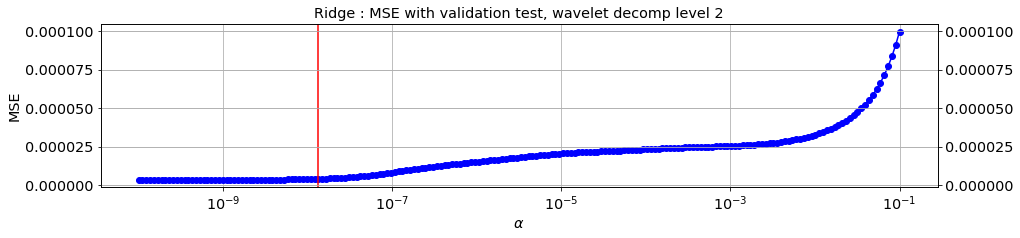

In [44]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")

#idx_min=np.where(all_MSE<RIDGE_MSE_THRES[ilevel])[0][-1]
idx_min=np.where(all_MSE<RIDGE_MSE_THRES[ilevel])[0][-1]

alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test, "+ilevel_label)
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()
alpha_ridge

### Display results

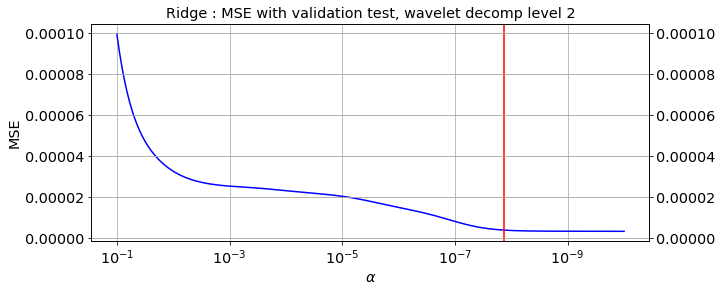

In [45]:
fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.grid()
ax.set_title("Ridge : MSE with validation test, "+ilevel_label)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

In [46]:
alpha_ridge_sel=alpha_ridge
alpha_ridge_label="($\\alpha$ = {:1.3e})".format(alpha_ridge_sel)

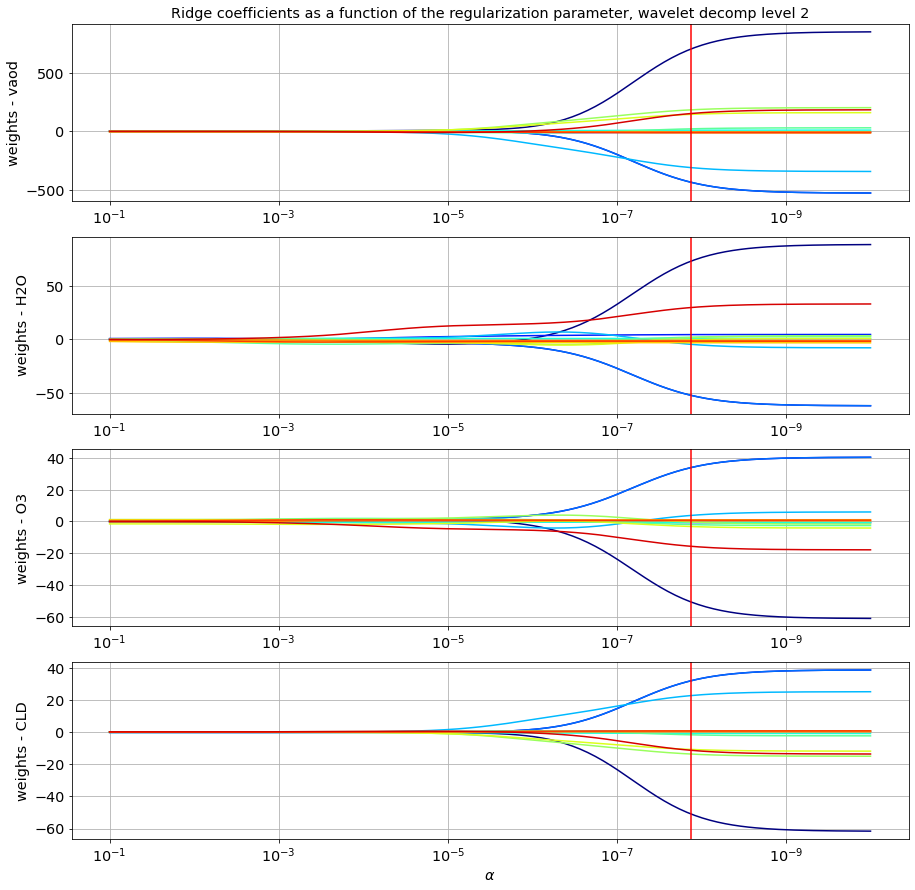

In [47]:
fig=plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.axvline(x=alpha_ridge_sel,color='red')
ax1.set_title('Ridge coefficients as a function of the regularization parameter, '+ ilevel_label)

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.axvline(x=alpha_ridge_sel,color='red')
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.axvline(x=alpha_ridge_sel,color='red')
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax4.plot(alphas, allcoefs[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.axvline(x=alpha_ridge_sel,color='red')
ax4.grid(True)


plt.xlabel('$\\alpha$')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [48]:
from sklearn import linear_model

In [49]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [50]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

Coefficients: 
 [[ 6.36439647e-01 -9.12482857e-02  3.34761584e+00 -3.14012027e-02
  -2.15422137e+00  1.08848259e+00  1.06576686e+00 -3.32951809e-01
   8.63635761e-01 -1.43733428e+00 -1.83133469e+00  1.14510611e+00
  -1.17141758e+00]
 [ 2.30627350e-01 -7.21670856e-03  4.67428661e-01 -3.10987881e-03
  -5.38975591e-01 -2.81116199e-01  2.39999894e-01  3.74789632e-01
  -4.30611724e-01 -5.44130022e-01 -1.02276814e+00  9.03732473e-01
  -3.67527440e-01]
 [-3.21582753e-02  6.49787127e-04 -9.10716379e-02  1.90286195e-03
   1.32550046e-01  1.51456726e-01  1.09018883e-01  7.57110034e-01
  -1.65420737e+00  1.00866157e+00 -6.91195171e-01  2.54181009e-01
  -3.92057984e-02]
 [ 9.54207713e-01  7.97908864e-03 -2.32929800e-01  2.18492092e-03
   1.39302500e-01 -6.97965345e-02 -5.84706961e-02  2.96843020e-02
  -4.74112599e-02  9.47327130e-02  1.34139984e-01 -6.89955584e-02
   7.37346223e-02]]
Mean squared error: 0.00188
Coefficient of determination: 0.99818
Explained variance: 0.99818


/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.201529937747763, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6141413214160771, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25193749365930035, tolerance: 0.2190000000000001
  positive)


In [51]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -1, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.044651043594458, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.56361541901078, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.044651043594607, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.047927730272407, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5646666425905418, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.054402704843304, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.803359733297174, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.319434488851138, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8896925763675763, tolerance: 0.219
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase th

<Figure size 1080x1080 with 0 Axes>

In [52]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [53]:
alpha_lasso_min=alphas[idx_min]
alpha_lasso_min

1e-10

In [54]:
ilevel_label

'wavelet decomp level 2'

In [55]:
LASSO_MSE_THRES=[
    1e-7,
    0.05,      #level 1
    2e-3,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

0.0001438449888287663

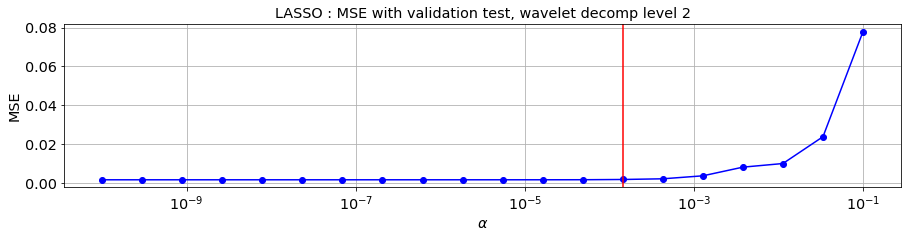

In [56]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")

#idx_min=np.where(all_MSE==all_MSE.min())[0][0]
idx_min=np.where(all_MSE<LASSO_MSE_THRES[ilevel])[0][-1]


alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test, "+ilevel_label)
ax.grid()
alpha_lasso

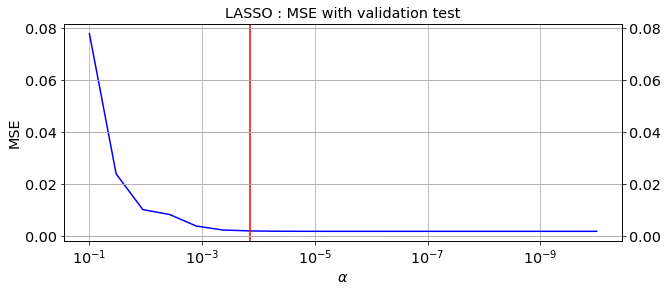

In [57]:
fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.grid()
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

In [58]:
# Final selection
alpha_lasso_sel=alpha_lasso
alpha_lasso_label="( $\\alpha$ = {:1.3e})".format(alpha_lasso_sel)

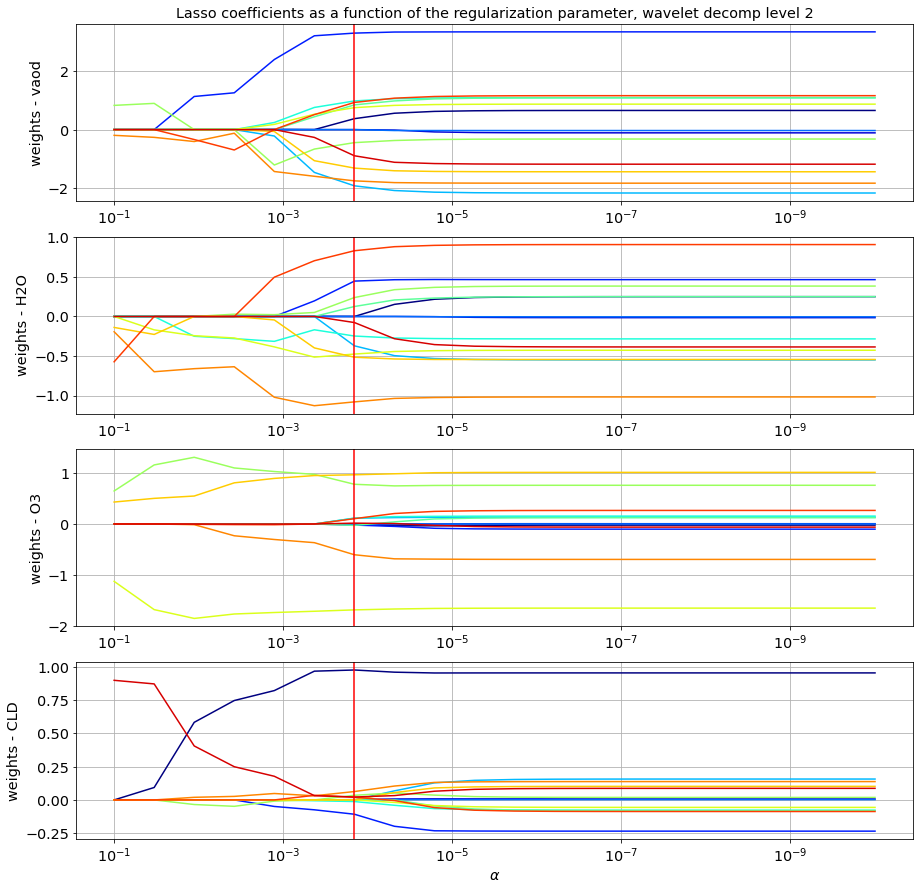

In [59]:
fig=plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.axvline(x=alpha_lasso_sel,color='red')
ax1.set_title('Lasso coefficients as a function of the regularization parameter, '+ilevel_label)

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.axvline(x=alpha_lasso_sel,color='red')
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.axvline(x=alpha_lasso_sel,color='red')
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax4.plot(alphas, allcoefs2[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.axvline(x=alpha_lasso_sel,color='red')
ax4.grid(True)

plt.xlabel('$\\alpha$')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [60]:
nb_tot_test=len(Y_test)
nb_tot_train=len(Y_train)

In [61]:
nsamples_test=np.arange(10,nb_tot_test,10)
nsamples_train=np.arange(10,nb_tot_train,10)

### Leraning curves for linear regression

In [62]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [63]:
count=0
for n in nsamples_train:
    
    regr = linear_model.LinearRegression(fit_intercept=True)
  
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    regr.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = regr.predict(X_train_cut)
    
    
    if n in nsamples_test:
        Y_pred_test  = regr.predict(X_test_cut)
        
    if FLAG_SCALING:     
        Y_pred_test_full = regr.predict(np.copy(X_test_scaled))
    else:
        Y_pred_test_full = regr.predict(np.copy(X_test))
        
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full)
            

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

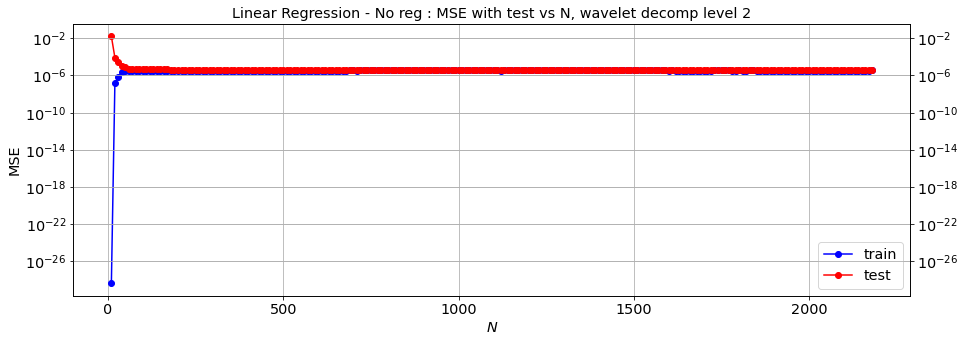

In [64]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("Linear Regression - No reg : MSE with test vs N, "+ilevel_label)
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Ridge

In [65]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [66]:
count=0
for n in nsamples_train:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge_sel, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = ridge.predict(X_test_scaled)
    else:
        Y_pred_test_full = ridge.predict(X_test)
        
    if n in nsamples_test:
        Y_pred_test  = ridge.predict(X_test_cut)
        
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full) 
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

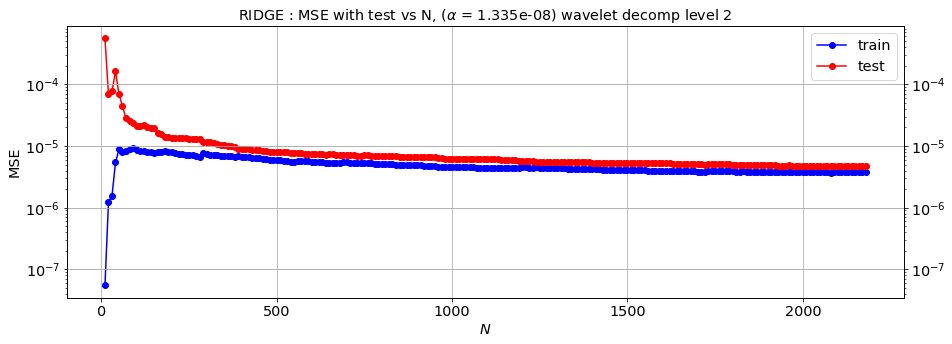

In [67]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N, "+ alpha_ridge_label+" "+ ilevel_label)
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Lasso

In [68]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [69]:
count=0
for n in nsamples_train:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso_sel, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:])
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = lasso.predict(X_test_scaled)
    else:
        Y_pred_test_full = lasso.predict(X_test)
    
    if n in nsamples_test:
        Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full) 
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020745927167096667, tolerance: 0.0009938346153402725
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018365634401278715, tolerance: 0.0003225237752955068
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003649093610452513, tolerance: 0.0007725971819792289
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7518294445587987, tolerance: 0.01663285626655666
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2108629883727886, tolerance: 0.02326050280238628
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0612687235435933, tolerance: 0.021852152531802886
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.338657579500984, tolerance: 0.03013450158631399
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38033167831694226, tolerance: 0.04280993391897208
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11395651079293553, tolerance: 0.038274926728331535
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.816792353180769, tolerance: 0.04143188712123035
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5065264510366725, tolerance: 0.056000269666033956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15110598507770973, tolerance: 0.04735388008159984
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5990958470982952, tolerance: 0.06597259900656766
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20551816284937577, tolerance: 0.06302016659045005
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.302457555509771, tolerance: 0.058335922644011294
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7082317299574328, tolerance: 0.06865734527609188
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6988876313090133, tolerance: 0.07742094082698195
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23206135552844576, tolerance: 0.07551454733317449
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.14372905373107, tolerance: 0.07752192382300878
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8134495103245551, tolerance: 0.09029123797647098
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26150560916547716, tolerance: 0.08728940669223842
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.513446178455761, tolerance: 0.0886440198624991
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9040885607973981, tolerance: 0.09812609080538882
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2932283395453109, tolerance: 0.09906737013755813
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33825888016614525, tolerance: 0.11738238537318187
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.115775371607152, tolerance: 0.10599991630086529
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.042873684410496, tolerance: 0.11334010682274002
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6424879072826055, tolerance: 0.1230896455778822
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1600745958736915, tolerance: 0.1270244470342621
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37788880684247483, tolerance: 0.13372788503130617
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0410948986990265, tolerance: 0.1369548157631536
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2422735458191934, tolerance: 0.13609513713061516
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4149960601951769, tolerance: 0.14811191464567297
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.537159543309108, tolerance: 0.14660539630104855
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3546135011612885, tolerance: 0.149755139534612
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4487828900070508, tolerance: 0.15911323945136668
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4496836268226307, tolerance: 0.16041830332726556
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48249118024350574, tolerance: 0.16809110319569925
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.009915515675555, tolerance: 0.15969857638969406
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.3570033725390065, tolerance: 0.17183984678479
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.529911835160025, tolerance: 0.1708493721128471
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5238037017703449, tolerance: 0.17941004781287148
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.008347683726929, tolerance: 0.18283090162236298
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7266420152167266, tolerance: 0.19008827618883273
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5724621257867359, tolerance: 0.19384534867792091
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8110345163935233, tolerance: 0.19927561155868115
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6009838049568321, tolerance: 0.20292271365222297
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.478646836510755, tolerance: 0.196869345257496
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.835247880336571, tolerance: 0.20805096469722476
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9045089315518888, tolerance: 0.21010775435964607
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6398765523532267, tolerance: 0.21244066771762096
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

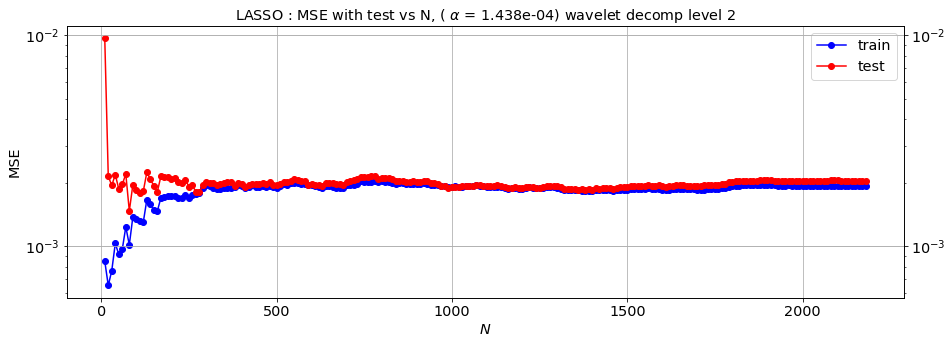

In [70]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N, "+ alpha_lasso_label+ " "+ ilevel_label)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

# Final

# No regularisation

In [71]:
regr = linear_model.LinearRegression(fit_intercept=True)
    
if FLAG_SCALING:           
    regr.fit(X_train_scaled,Y_train_scaled)
else:
    regr.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = regr.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = regr.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [72]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


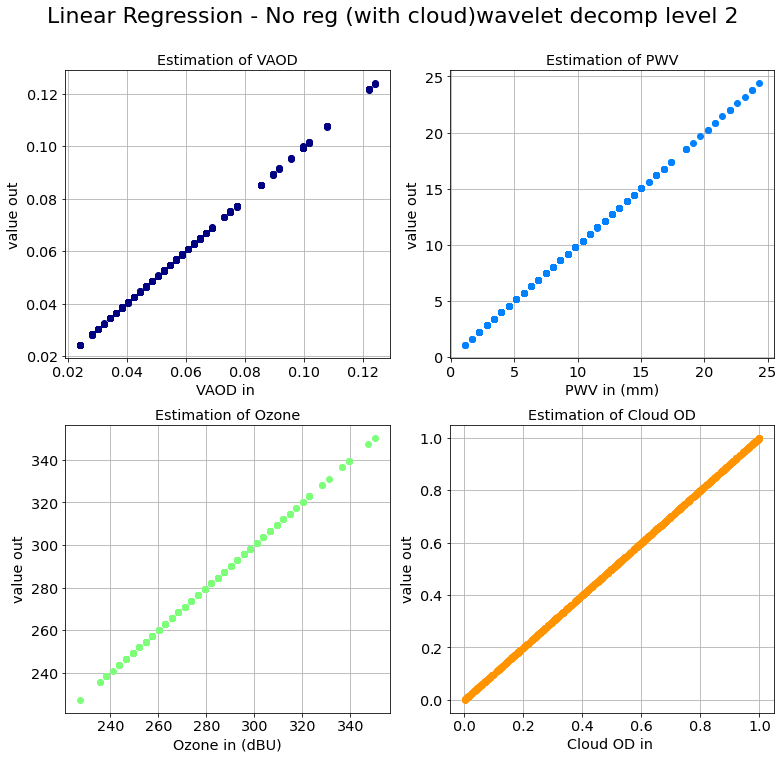

In [73]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()


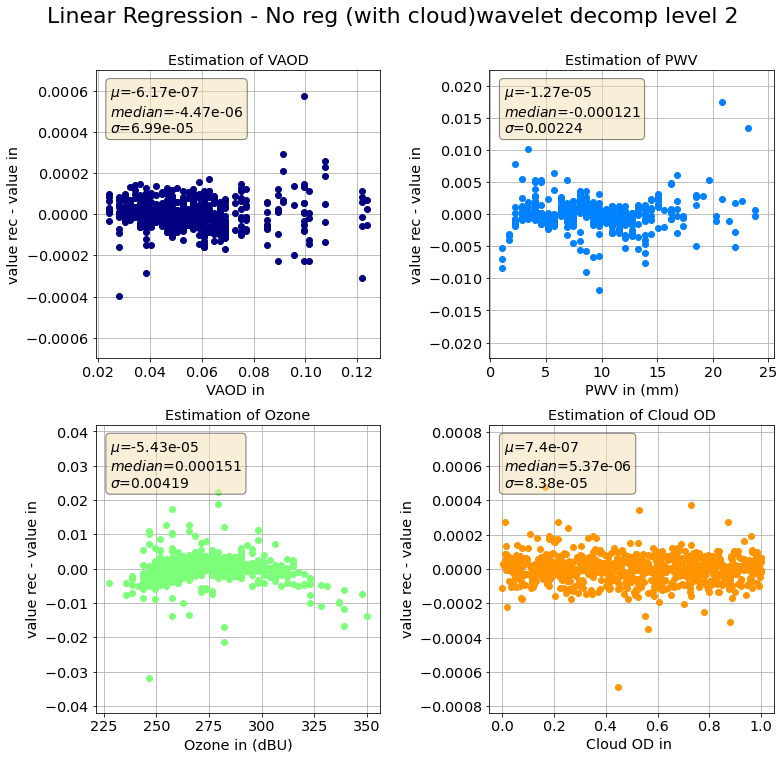

In [74]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()


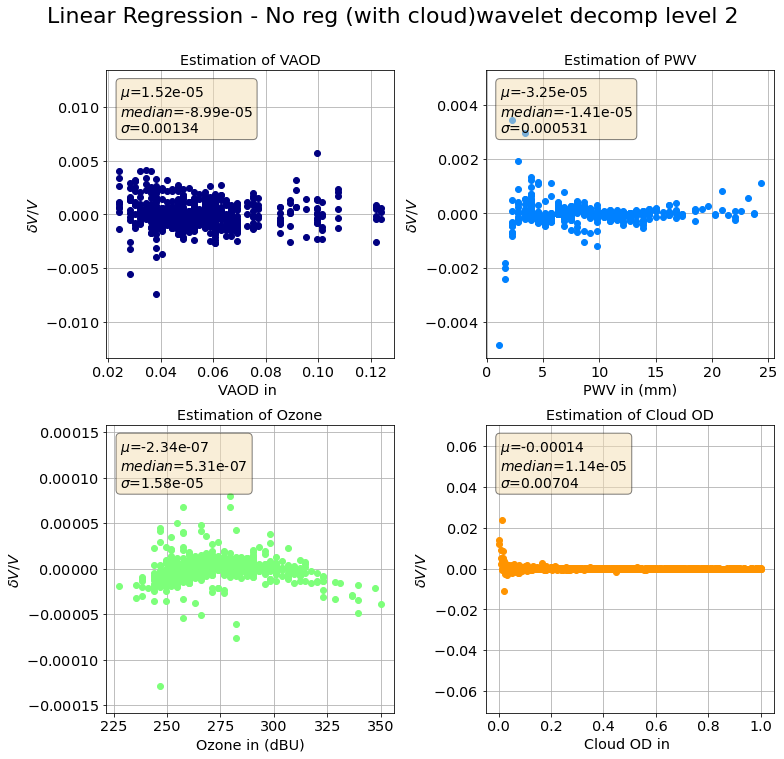

In [75]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()

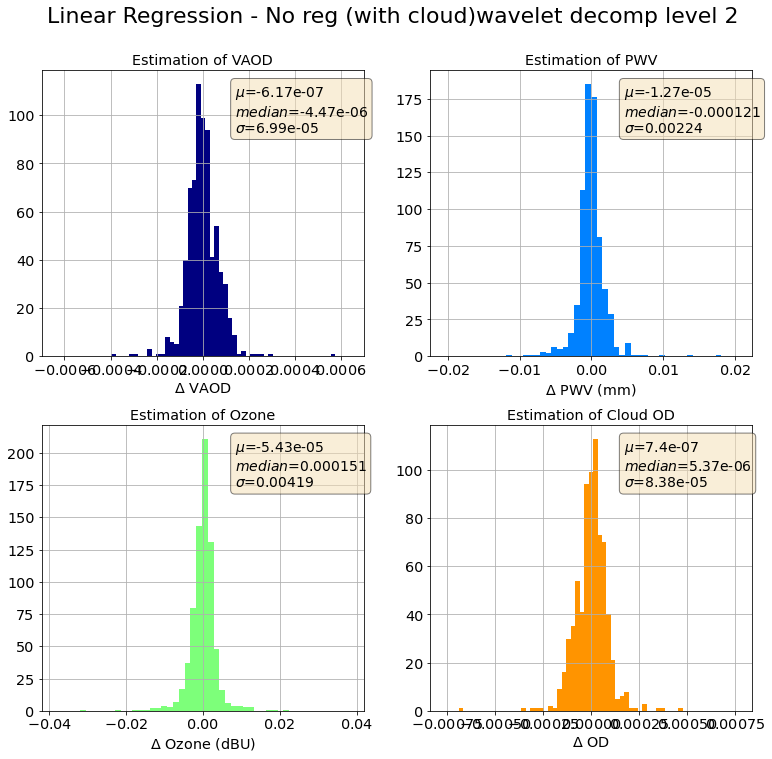

In [76]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()

## Ridge

In [77]:
ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


In [78]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


In [79]:
ridge.coef_

array([[ 8.51266134e+02, -5.27424281e+02, -7.77300920e+00,
        -5.27422265e+02, -3.43088740e+02,  1.08008921e+01,
         3.04066135e+01,  2.02836798e+02,  1.59940136e+02,
        -1.22066025e+01, -4.41820410e+00, -1.24366187e+01,
         1.84197301e+02],
       [ 8.85932002e+01, -6.18583002e+01,  4.66472617e+00,
        -6.18576015e+01, -7.78529319e+00,  1.09544922e+00,
         3.08166054e+00,  3.48592104e+00,  1.07386216e+00,
        -3.14054836e+00, -8.85129218e-01, -1.70316941e+00,
         3.31303911e+01],
       [-6.11157813e+01,  4.03600714e+01, -8.35153285e-01,
         4.03597332e+01,  5.92260358e+00, -6.70376731e-01,
        -2.64838692e+00, -1.67054649e+00, -4.18698894e+00,
         1.05468835e+00,  3.37975294e-01,  7.85396942e-01,
        -1.79128727e+01],
       [-6.16209146e+01,  3.88000057e+01,  5.88400367e-01,
         3.87998578e+01,  2.52574432e+01, -7.94623931e-01,
        -2.23672697e+00, -1.49437842e+01, -1.17682114e+01,
         8.98021223e-01,  3.25039545e

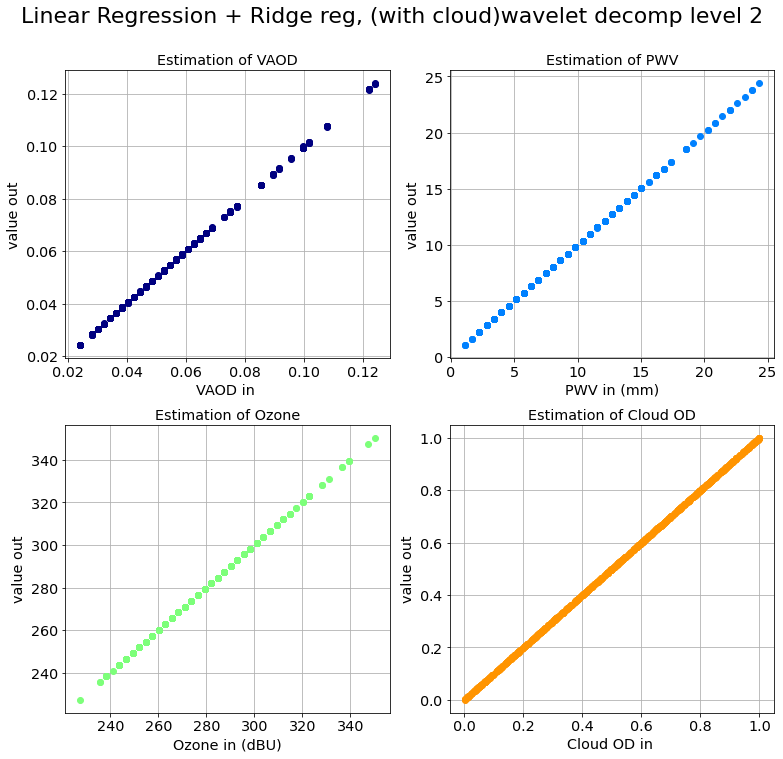

In [80]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()

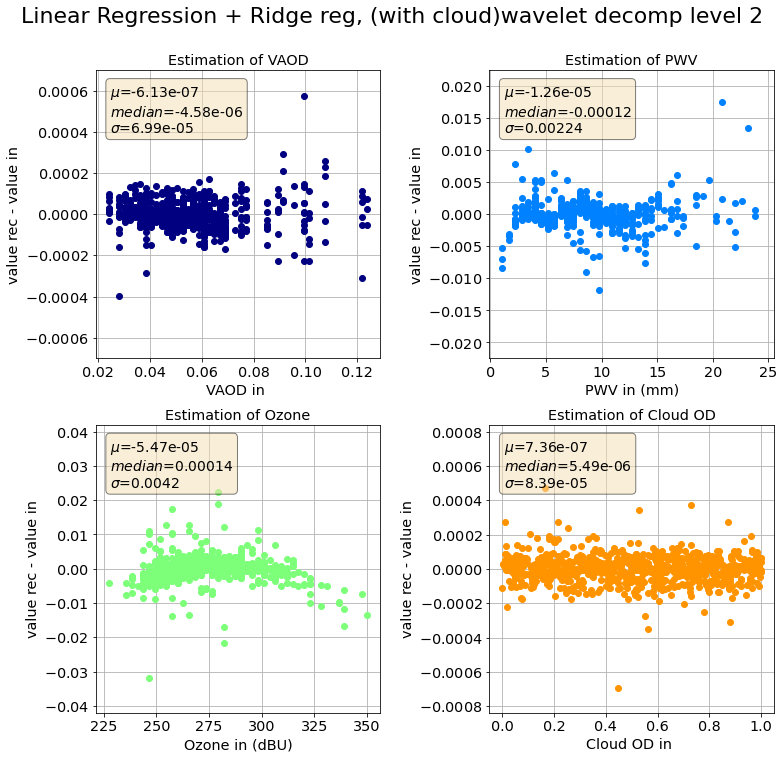

In [81]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()


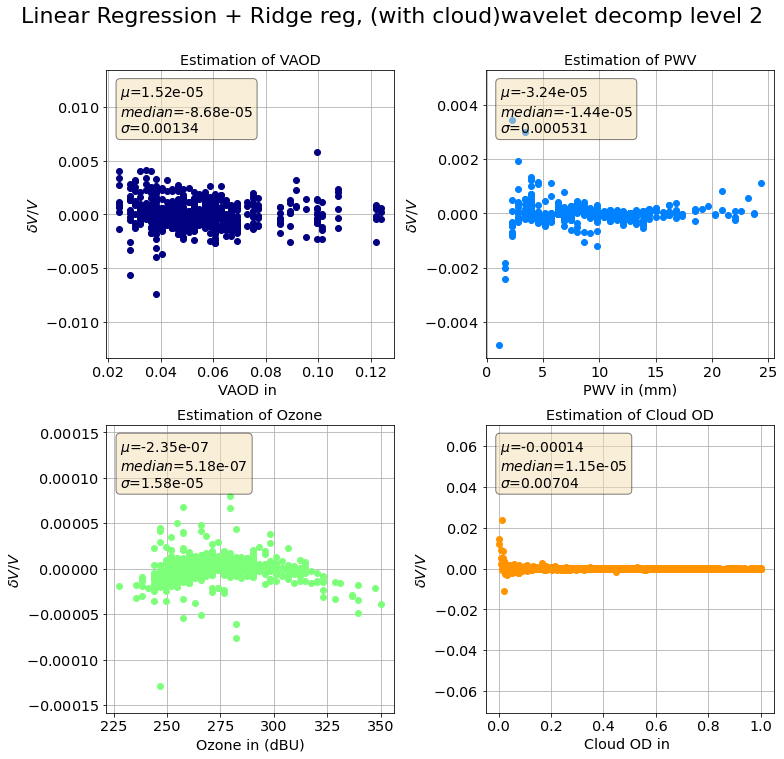

In [82]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()

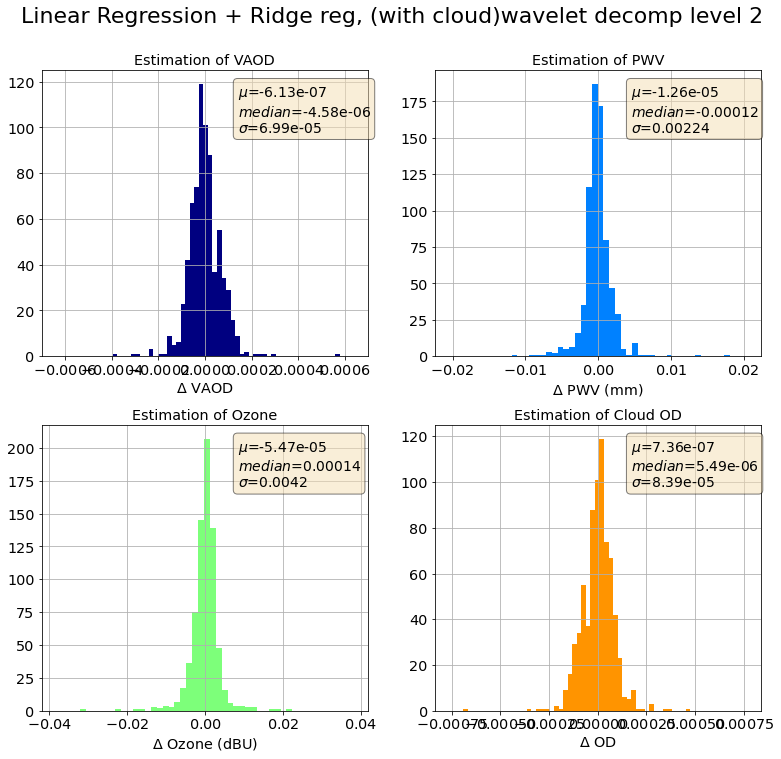

In [83]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()

## Lasso

In [84]:
#lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.044651043594458, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.56361541901078, tolerance: 0.21899999999999992
  positive)


In [85]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00187
Coefficient of determination: 0.99818
Explained variance: 0.99818


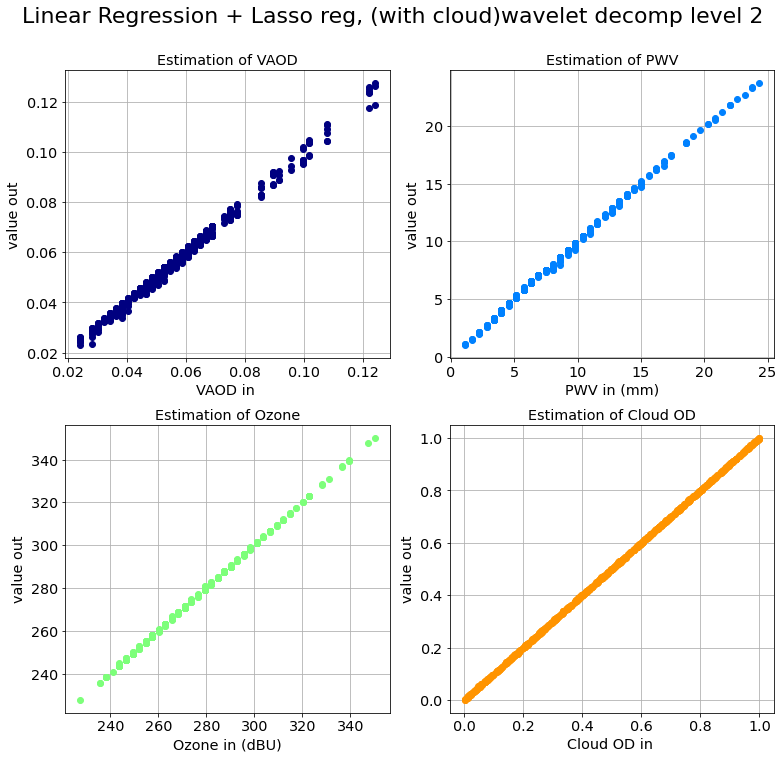

In [86]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()

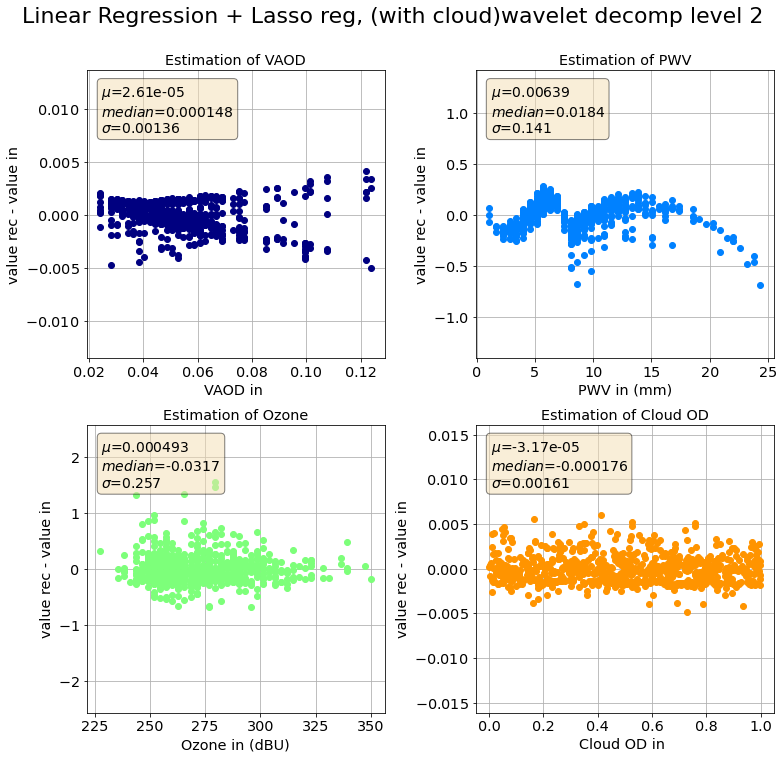

In [87]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()



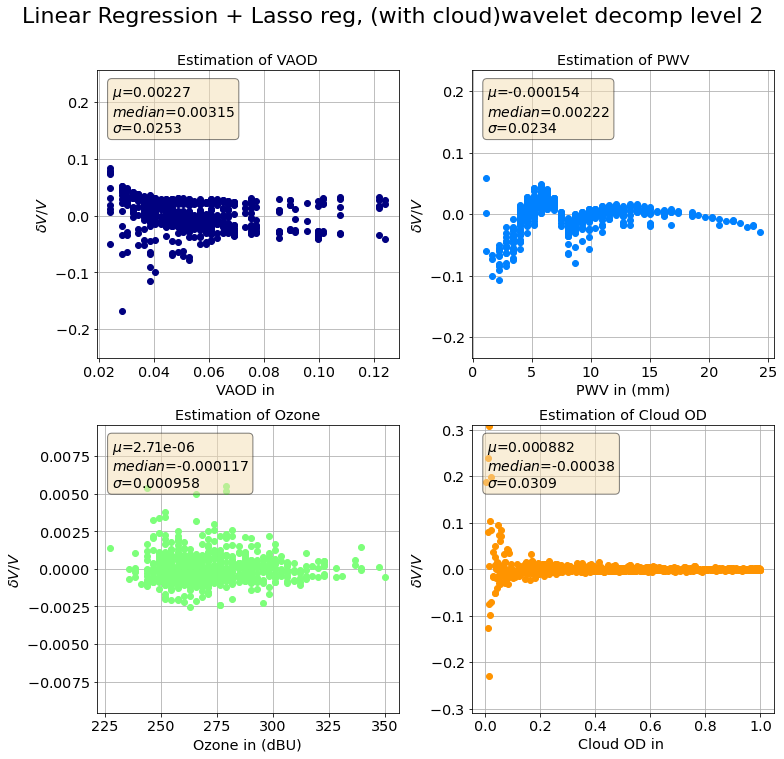

In [88]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()

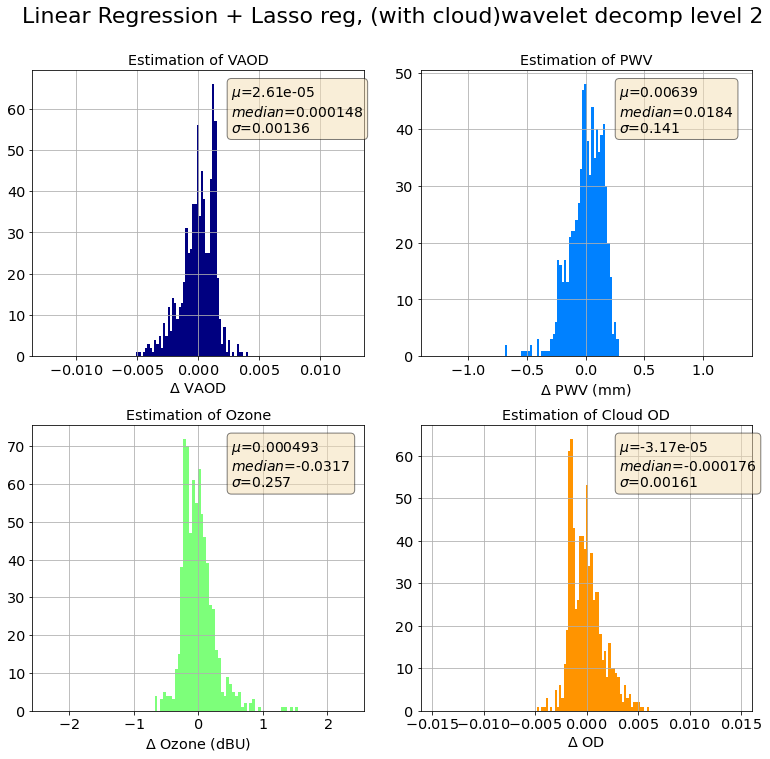

In [89]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)"+ilevel_label,Y=1.05,fontsize=22)

plt.show()
